## Imports

In [1]:


import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='../Notebook_files/data', train=True, download=True, transform=transform)
test_dataset=torchvision.datasets.CIFAR10(root='../Notebook_files/data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Notebook_files/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [10]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Notebook_files/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [11]:
torch.manual_seed(101)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [12]:
class_names = "plane car bird cat deer dog frog horse ship truck".split(" ")
class_names

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [13]:
for images, labels in train_dataloader:
    break

In [14]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [1 5 8 1 6 1 6 3 7 9]
Class: car dog ship car frog car frog cat horse truck


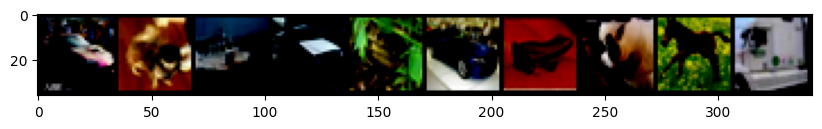

In [15]:
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=10)

plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

## Simplified ResNet-18 Model for the CIFAR 10 dataset

In [16]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    
# Defining the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [17]:
def train_model(num_of_runs=1, epochs=20, batch_size=32, learning_rate=0.001):
    # Configuration parameters
    epochs = epochs
    batch_size = batch_size
    lr = learning_rate

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    all_train_losses, all_val_losses, all_accuracies = [], [], []

    for run_idx in range(1, num_of_runs + 1):
        # Loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Model, Loss, and Optimizer
        model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_losses, val_losses, accuracies = [], [], []

        for epoch in range(epochs):
            model.train()
            total_train_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_func(outputs, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item() * images.size(0)

            # Calculate average training loss for the epoch
            avg_train_loss = total_train_loss / len(train_loader.dataset)

            # Validation phase
            val_loss, accuracy = validate_model(model, val_loader, loss_func, device)
            
            train_losses.append(avg_train_loss)
            val_losses.append(val_loss)
            accuracies.append(accuracy)

            print(f"Epoch {epoch + 1}: Train Loss: {avg_train_loss:.3f}, Valid Loss: {val_loss:.3f}, Accuracy: {accuracy:.2f}")

        
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_accuracies.append(accuracies)
        
        # Save the model
        model_path = f'cifar10_model{run_idx}.pth'
        torch.save(model.state_dict(), model_path)

    print("Training complete.")
    return model, train_loader, val_loader, (all_train_losses, all_val_losses, all_accuracies)




def validate_model(model, val_loader, loss_func, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Calculate the loss
            loss = loss_func(outputs, labels)
            total_val_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    accuracy = correct_predictions / total_predictions

    return avg_val_loss, accuracy

In [18]:
def evaluate_and_plot_metrics(model, train_loader, val_loader, metrics):
    all_train_losses, all_val_losses, all_accuracies = metrics
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Calculate Precision, Recall, F1 Score, and Confusion Matrix using validation data
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1_score}")

    # Plotting
    plt.figure(figsize=(18, 7))

    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(np.mean(all_train_losses, axis=0), label='Train Loss')
    plt.plot(np.mean(all_val_losses, axis=0), label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(np.mean(all_accuracies, axis=0), label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot confusion matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.tight_layout()
    plt.show()

In [ ]:
model, train_loader, val_loader, metrics = train_model()

Precision: 0.5474578775292949
Recall: 0.5393
F1 Score: 0.5407050208643057


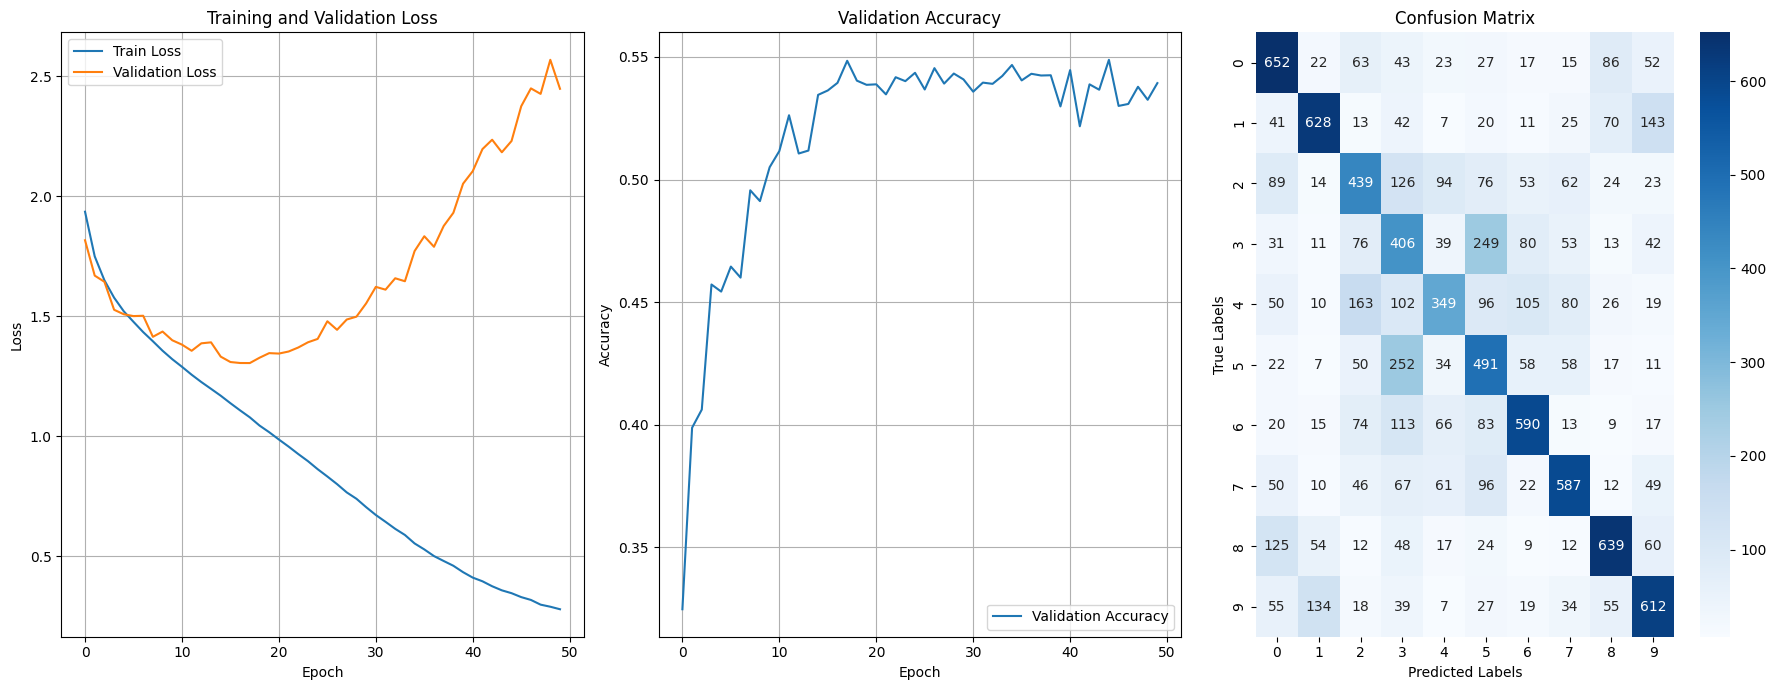

In [16]:
evaluate_and_plot_metrics(model, train_loader, val_loader, metrics)